In [0]:
!pip install --upgrade -q opencv-contrib-python

In [0]:
# Import required pacakges
import numpy as np

# ML packages
import tensorflow as tf

# Visualization packages
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

import cv2

%matplotlib inline

In [3]:
# Create the 2-D dataset of points in range [0, 1)
numSamples = 200
numDimensions = 2

trainDataPoints = np.array([np.random.rand(numSamples,), np.random.rand(numSamples,)]).T
testDataPoints = np.array([np.random.rand(numSamples,), np.random.rand(numSamples,)]).T

# Desired ellipse params
# (x - x0)^2/a^2 + (y - y0)^2/b^2 = r^2
center = (np.random.random(), np.random.random())
a = np.random.random()
b = np.random.random()
r = np.random.normal(loc=0.5, scale=0.15)
print ("Data params | Center: %s | a: %f | b: %f | r: %f" % (str(center), a, b, r))

trainLabels = ((np.square(trainDataPoints[:, 0] - center[0]) / np.square(a)) + (np.square(trainDataPoints[:, 1] - center[1]) / np.square(b)) > np.square(r))
testLabels = ((np.square(testDataPoints[:, 0] - center[0]) / np.square(a)) + (np.square(testDataPoints[:, 1] - center[1]) / np.square(b)) > np.square(r))

trainLabelsFloat = trainLabels.astype(float)
testLabelsFloat = trainLabels.astype(float)

outerPoints = trainDataPoints[trainLabels]

Data params | Center: (0.7591445840052834, 0.2840649937960117) | a: 0.738812 | b: 0.592362 | r: 0.511187


In [0]:
def drawEllipse(
        img, center, axes, angle,
        startAngle, endAngle, color,
        thickness=3, lineType=cv2.LINE_AA, shift=10):
    center = (
        int(round(center[0] * 2**shift)),
        int(round(center[1] * 2**shift))
    )
    axes = (
        int(round(axes[0] * 2**shift)),
        int(round(axes[1] * 2**shift))
    )
    cv2.ellipse(
        img, center, axes, angle,
        startAngle, endAngle, color,
        thickness, lineType, shift)

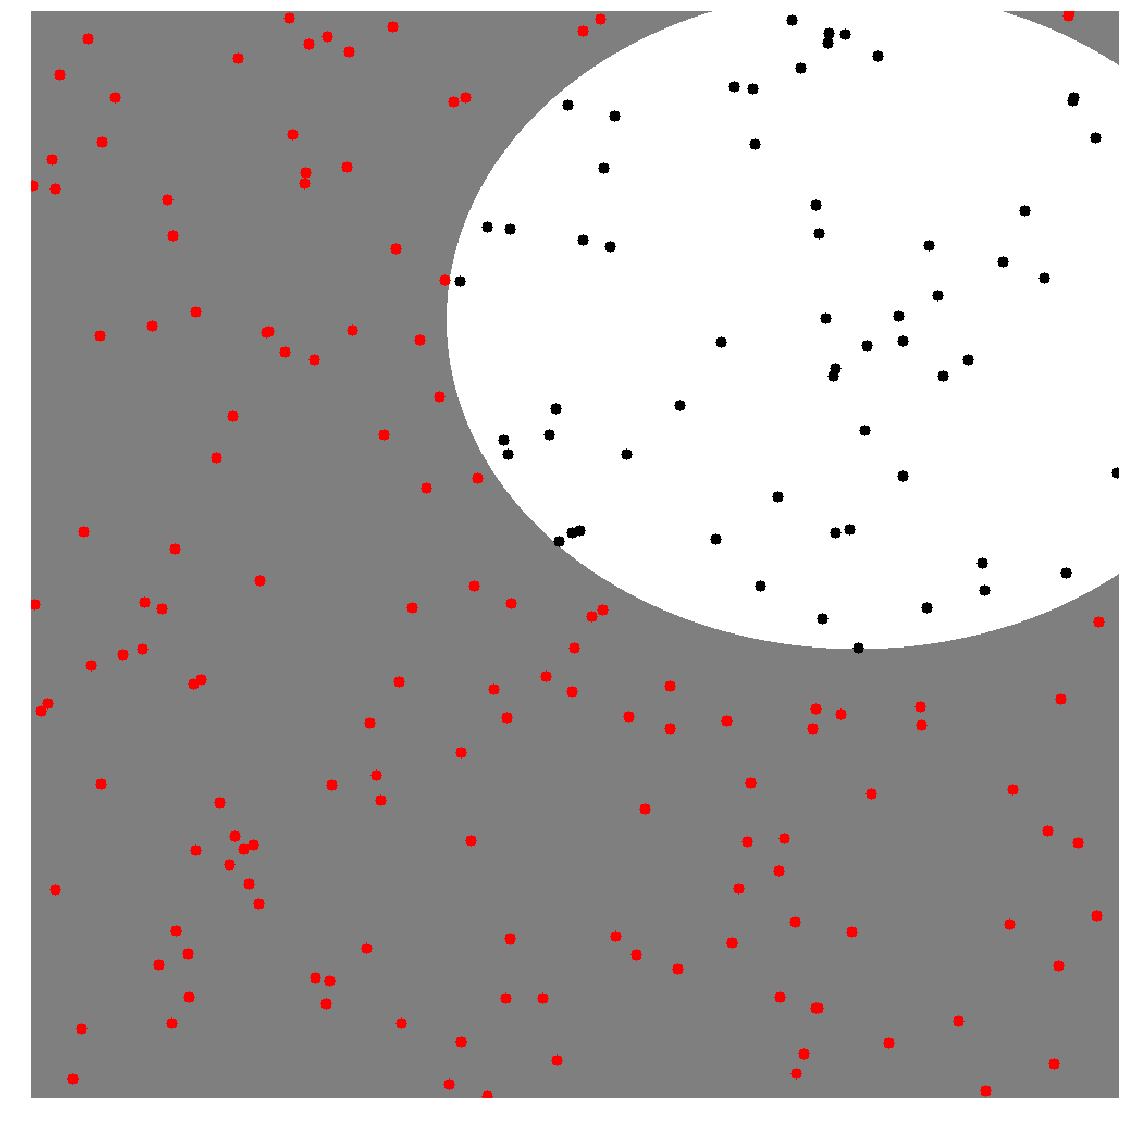

In [24]:
# Create the data set plot
plt.rcParams['figure.figsize'] = [20, 20]
plotDim = 1000
dataPlot = np.ones((plotDim, plotDim, 3), dtype=np.float32)
scaledIndices = np.floor(trainDataPoints * plotDim).astype(np.int32)

# Create decision boundary meshgrid
for x in range(plotDim):
  for y in range(plotDim):
    # Exchange x and y because of i and j
    gridLabel = ((np.square((y / plotDim) - center[0]) / np.square(a)) + (np.square((x / plotDim) - center[1]) / np.square(b)) > np.square(r))
    if gridLabel:
      dataPlot[x, y, :] = [0.5, 0.5, 0.5]

for i in range(scaledIndices.shape[0]):
  color = (0.0, 0.0, 0.0)
  if trainLabels[i]:
    color = (1.0, 0.0, 0.0) # RGB
  
  cv2.circle(dataPlot, (scaledIndices[i, 0], scaledIndices[i, 1]), 5, color, -1)

#drawEllipse(dataPlot, center=center, axes=((a, b) if a > b else (b, a)), angle=0.0, startAngle=0.0, endAngle=360, color=(1.0, 0.0, 1.0), thickness=50)

plt.tight_layout()
plt.axis('off')
plt.imshow(dataPlot)

In [0]:
# Perform polynomial logistic regression
numIterations = 1000
learningRate = 1e-1

# Clear previous graph
tf.reset_default_graph()

dataPointPlaceholder = tf.placeholder(tf.float32, shape=(None, numDimensions), name="dataPointPlaceholder")
labelPlaceholder = tf.placeholder(tf.float32, shape=(None,), name="labelPlaceholder")

# Create the model variables
def addMLPNode(dataInput, outDim):
	W = tf.Variable(tf.random_normal([int(dataInput.get_shape()[-1]), outDim]))
	b = tf.Variable(tf.zeros([outDim]))
	y = tf.matmul(dataInput, W) + b
	return y

# Create the model
hiddenDimension = 10
mlp = tf.nn.tanh(addMLPNode(dataPointPlaceholder, hiddenDimension))
mlp = tf.nn.sigmoid(addMLPNode(mlp, 1))
y = tf.reshape(mlp, [-1])
print (y.get_shape())

# Define the loss function
epsilon = 1e-8
with tf.name_scope('loss') as scope:
	loss = - (labelPlaceholder * tf.log(y + epsilon)) - ((1.0 - labelPlaceholder) * tf.log(1.0 - y + epsilon))
	loss = tf.reduce_mean(loss)
  
with tf.name_scope('accuracy'):
	correctPredictions = tf.equal(tf.round(y), tf.round(labelPlaceholder))
	accuracy = tf.reduce_mean(tf.cast(correctPredictions, tf.float32), name='accuracy')

with tf.name_scope('optimizer') as scope:
	optimizer = tf.train.AdamOptimizer(learning_rate=learningRate).minimize(loss)

In [0]:
# Train the model
print ("Training model")
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

with tf.Session(config=config) as sess:
  # Initializing the variables
  init = tf.global_variables_initializer()
  sess.run(init)

  for i in range(numIterations):
    _, trainLoss, trainAccuracy = sess.run([optimizer, loss, accuracy], feed_dict={dataPointPlaceholder: trainDataPoints, labelPlaceholder: trainLabelsFloat})
    print ("Iteration: %d | Loss: %f | Accuracy: %f" % (i + 1, trainLoss, trainAccuracy))
  print ("Training finished!")

  # Generate predictions on the test set
  testSetPredictions, testLoss, testAccuracy = sess.run([y, loss, accuracy], feed_dict={dataPointPlaceholder: testDataPoints, labelPlaceholder: testLabelsFloat})
  
  # Get decision boundary
  testSetPredictions, testLoss, testAccuracy = sess.run([y, loss, accuracy], feed_dict={dataPointPlaceholder: testDataPoints, labelPlaceholder: testLabelsFloat})

In [0]:
print ("Test Loss: %f | Test Accuracy: %f" % (testLoss, testAccuracy))

testSetPredictions = np.squeeze(testSetPredictions)
threshold = 0.5
testSetPredictions = testSetPredictions > threshold

In [0]:
# Create the predictions plot
fig2, ax2 = plt.subplots()
ax2.scatter(testDataPoints[:, 0], testDataPoints[:, 1], c='g')

outsidePointsTestSet = testDataPoints[testSetPredictions]
ax2.scatter(outsidePointsTestSet[:, 0], outsidePointsTestSet[:, 1], c='r')

ellipseTwo = Ellipse(xy=center, width=(r * 2), height=(r * 2), angle=0.0, fill=False, color='y') # Draw the original ellipse
ax2.add_patch(ellipseTwo)
ax2.set_title('Test data')

plt.show()